#　Batch NormalizationとLayer Normalization

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

## Hook

- Hookを使ってActivationの情報を取得する
    - NNモデルの層(nn.Module)やtensorに対して勾配計算時などのタイミングで特定の関数を実行することが可能
    - tensorに対しては.register_hook()を使用する。tensorの勾配計算の直後に引数でワタｗした関数を実行する
    - nn.Moduleに対しては以下のメソッドでhookを登録する
        - Forward hook
            - nn.Moduleのforwardメソッドが呼び出された直後に実行される関数を定義
            - 特定の層の出力を記録できる
            - nn.Moduleオブジェクトに対して.register_forward_hook()に関数を渡す
        - Backward_hook
            - 逆伝播の間に勾配計算が行われた直後に実行される関数を定義
            - 勾配の値を記録したり、購買に変更を加えたりすることが可能
            - nn.Moduleオブジェクトに対して、register_full_backward_hook()に関数を渡す
            - .register_backward_hook()はPython1.9以降非推奨

### .register_hook
- register_hook(func)メソッドでそのtensorの.gradが計算された時に、引数に渡した関数を実行する
- 引数の関数funcは、そのtensorの勾配(.grad)を引数に受け取る
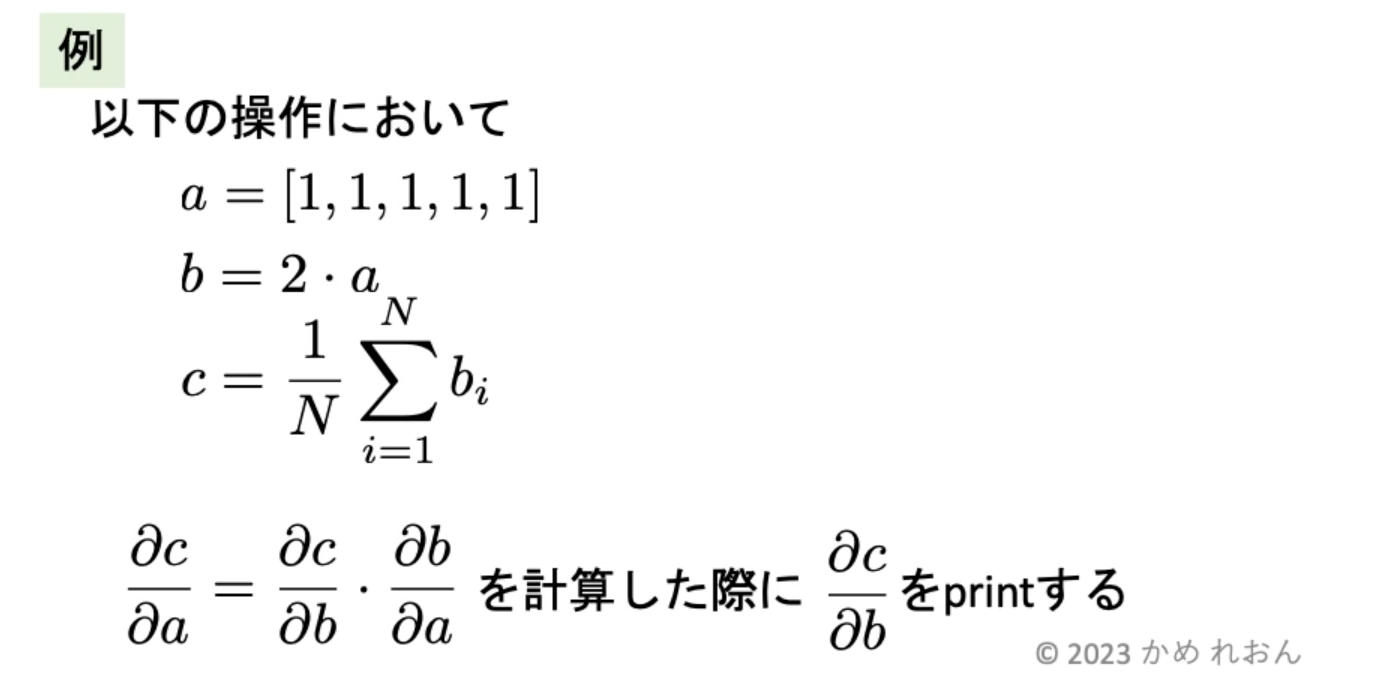

In [2]:
a = torch.ones(5, requires_grad=True)
b = 2 * a
b.retain_grad()
# def print_grad(grad):
#     print(grad)
# b.register_hook(print_grad)
b.register_hook(lambda grad: print(grad))
c = b.mean()
print(a, b ,c)

# 中間勾配を確認するためのbackward
c.backward()

tensor([1., 1., 1., 1., 1.], requires_grad=True) tensor([2., 2., 2., 2., 2.], grad_fn=<MulBackward0>) tensor(2., grad_fn=<MeanBackward0>)
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


### .register_forward

forward_hook

- nn.Moduleに対して.register_hook(func)でhookを登録する
- model.named_modules()等でモデルのモジュールをイテレーションすることで、モデルの各層(モジュール)にhookをつけることができる
- 自動で3つの引数を受け取る
    - module: hookが登録されているモジュールそのもの(nn.Module)
    - imp: そのモジュールの入力
    - out: そのモジュールの出力

In [3]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    
    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)
outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape
for name, module in conv_model.named_modules():
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_forward_hook(partial(save_output, name))

In [4]:
# hookがついているか確認する関数
def print_hooks(model):
    for name, module in conv_model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook: {hook}')
    
        if hasattr(module, "_backward_hooks"):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook: {hook}')

In [5]:
print_hooks(conv_model)

Module 0 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '0')
Module 1 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '1')
Module 2 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '2')
Module 3 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '3')
Module 4 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '4')
Module 5 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '5')
Module 6 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '6')
Module 7 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '7')
Module 8 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '8')
Module 9 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '9')


In [6]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
# forwardでhook発動
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)

In [8]:
outputs

{'0_Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 4, 14, 14]),
 '1_ReLU()': torch.Size([1, 4, 14, 14]),
 '2_Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 8, 7, 7]),
 '3_ReLU()': torch.Size([1, 8, 7, 7]),
 '4_Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 16, 4, 4]),
 '5_ReLU()': torch.Size([1, 16, 4, 4]),
 '6_Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 32, 2, 2]),
 '7_ReLU()': torch.Size([1, 32, 2, 2]),
 '8_Flatten(start_dim=1, end_dim=-1)': torch.Size([1, 128]),
 '9_Linear(in_features=128, out_features=10, bias=True)': torch.Size([1, 10])}

#### partial
- functools.partialを使って、関数の一部の引数を固定して新しい関数を作成できる
- partial(func, *args, **keyworads)の形で使用

In [9]:
# partialの使い方
# partial関数を使って、一部の引数を固定することができる
from functools import partial

# 元となる関数の定義
def power(base, exponent):
    return base ** exponent
# 部分適用した関数の作成
square = partial(power, exponent=2)
# 部分適用した関数の利用
print(square(5))

25


### .register_full_backward_hook

backward_hook

- nn.Moduleに対して.register_full_backward_hook(func)でhookを登録する
    - モジュールの入力と出力勾配に対するhookを設定する
    - 勾配の変更や監視などの操作を実行したい時に使用
- module.named_modules()等でモデルのモジュールをイテレーションすることで、モデルの各層(モジュール)にhookをつけることができる
- .backward()で逆伝播をし、各モジュールの勾配を計算した後にhookを登録した関数が実行される
- 自動で3つのモジュールを受け取る
    - module: hookが登録されているモジュールそのもの(nn.Module)
    - grad_in: そのモジュールの入力の勾配
    - grad_out: そのモジュールの出力の勾配

In [10]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
grads = {}
def save_grad_in(name, module, grad_in, grad_out):
    module_name = f'{name}_{str(module)}'
    grads[module_name] = grad_in
for name, module in conv_model.named_modules():
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_full_backward_hook(partial(save_grad_in, name))

In [12]:
# それぞれのhookにforwardとbackwardのhookがついているのがわかる
print_hooks(conv_model)

Module 0 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '0')
Module 0 has backward hook: functools.partial(<function save_grad_in at 0x7fc81ff04160>, '0')
Module 1 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '1')
Module 1 has backward hook: functools.partial(<function save_grad_in at 0x7fc81ff04160>, '1')
Module 2 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '2')
Module 2 has backward hook: functools.partial(<function save_grad_in at 0x7fc81ff04160>, '2')
Module 3 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '3')
Module 3 has backward hook: functools.partial(<function save_grad_in at 0x7fc81ff04160>, '3')
Module 4 has forward hook: functools.partial(<function save_output at 0x7fc8202660d0>, '4')
Module 4 has backward hook: functools.partial(<function save_grad_in at 0x7fc81ff04160>, '4')
Module 5 has forward hook: functools.partial(<function save_output at 

In [13]:
# backward
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)
loss = output.mean()
loss.backward()
grads

{'9_Linear(in_features=128, out_features=10, bias=True)': (tensor([[-0.0216, -0.0256, -0.0092, -0.0091, -0.0260, -0.0054, -0.0083,  0.0030,
           -0.0014,  0.0148, -0.0204, -0.0042, -0.0008, -0.0146,  0.0061, -0.0121,
            0.0139,  0.0202,  0.0135, -0.0233, -0.0194,  0.0012, -0.0022, -0.0074,
            0.0072,  0.0003,  0.0257, -0.0154, -0.0201, -0.0013, -0.0111, -0.0286,
            0.0062, -0.0173, -0.0025, -0.0106, -0.0185,  0.0007, -0.0186,  0.0083,
            0.0139,  0.0063, -0.0065,  0.0134, -0.0113,  0.0021,  0.0068,  0.0042,
           -0.0171,  0.0073, -0.0017, -0.0093,  0.0286, -0.0144, -0.0241,  0.0293,
            0.0254,  0.0101,  0.0137,  0.0135,  0.0046, -0.0497, -0.0125,  0.0081,
            0.0104, -0.0205, -0.0017,  0.0014, -0.0116,  0.0061, -0.0063,  0.0199,
            0.0008,  0.0040, -0.0015, -0.0325,  0.0004, -0.0111, -0.0015,  0.0083,
           -0.0122, -0.0029,  0.0162, -0.0197,  0.0062, -0.0078, -0.0082, -0.0196,
            0.0222,  0.0148, -

## Activationの分布

各層のactivation(活性化関数の出力)の分布を可視化する

- register_forward_hookを使って各ReLU層の出力の平均と標準偏差を記録する
- 実際に学習ループを回して、それぞれのReLU層の出力(activbation)の平均/標準偏差がどのように推移しているかを可視化する
- CNNを作成しFashion MNISTデータセットで学習

In [14]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    
    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

In [15]:
# 上記のActivation層の分布を保存するクラス
class ActivationStatistics:
    def __init__(self, model):
        self.model = model
        self.act_means = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # 学習データに対してのみActivationをtrackする
        if self.model.training:
            self.act_means[i].append(out.detach().cpu().mean().item())
            self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statistics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        axs[0].legend(range(len(self.act_means)))
        
        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation stds')
        axs[1].legend(range(len(self.act_stds)))

        plt.show()

In [16]:
act_stats = ActivationStatistics(conv_model)

In [17]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)

opt = optim.SGD(conv_model.parameters(), lr=0.6)

In [18]:
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 2.3058394011804615, validation error: 2.301634502410889, validation accuracy: 0.15931122452020646


epoch: 1: train error: 2.2662975101147667, validation error: 2.30148184299469, validation accuracy: 0.15635762065649034


epoch: 2: train error: 2.2808440398361722, validation error: 2.3024229288101195, validation accuracy: 0.10013751611113549


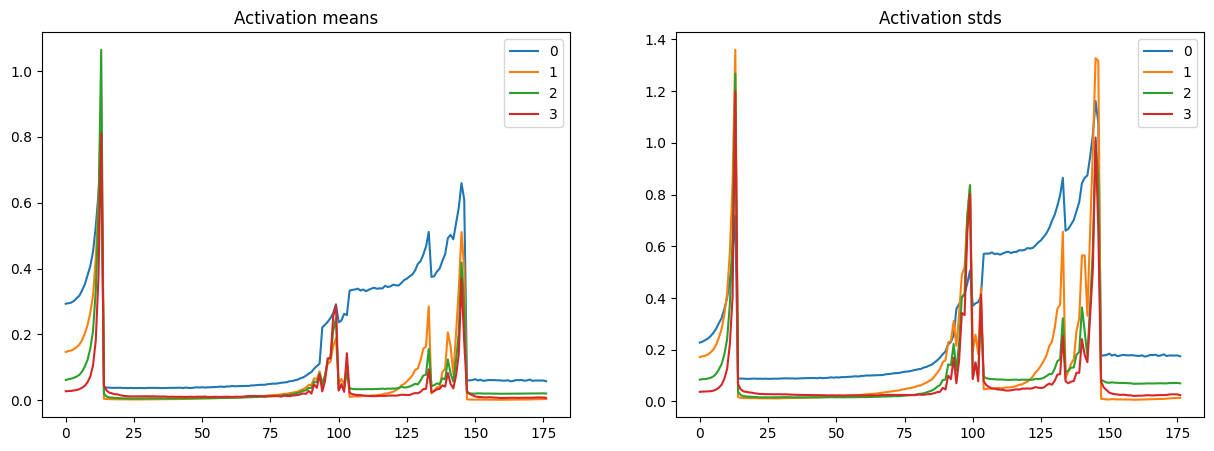

In [19]:
act_means, act_stds = act_stats.get_statistics()
act_stats.plot_statistics()

## Batch Normalization

### Batch Normのスクラッチ

- 入力tensorに対して平均と標準偏差を計算する
- スケーリングとシフトようの係数(gamma, beta)も引数として受け取る
    - 本来は学習可能なパラメータだが、交換の実装では引数として受け取る形を取る
- 入力tensorは[B, C, H, W]を想定する
- 予測時の対応は無視して良い
- 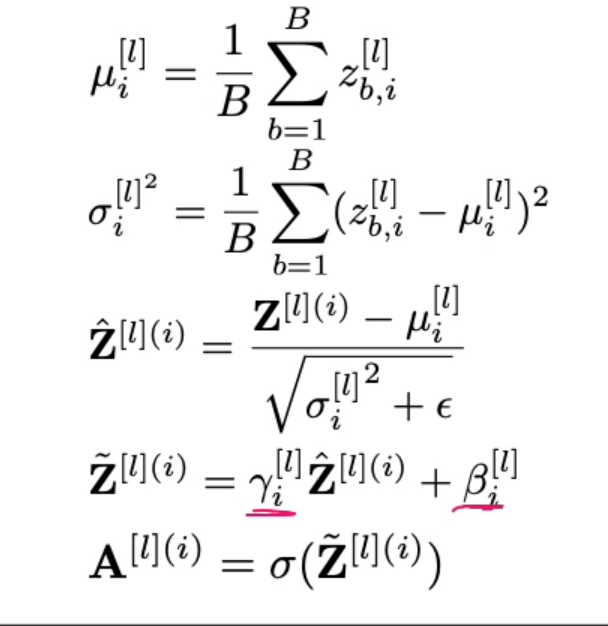

In [20]:
# 全結合の場合はX.shape = [b, out_features]
# dim=(0)で平均，分散を求める
def batch_norm(X, gamma=1, beta=0, eps=1e-5):
    mean = X.mean(dim=(0, 2, 3), keepdim=True)
    var = X.var(dim=(0, 2, 3), keepdim=True)
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma*X_norm + beta

In [21]:
X = torch.randn(8, 3, 16, 16)

In [22]:
X.shape

torch.Size([8, 3, 16, 16])

In [23]:
# [B, C, H, W]のうちバッチを跨いでチャネルごとに平均を取る
# そのため、平均は３次元必要
# dimを渡すｊことで、チャネル毎に平均を３種つくることができる
eps = 1e-5  # ゼロ除算を避けるための微小な数
mean = X.mean(dim=(0, 2, 3), keepdim=True)
var = X.var(dim=(0, 2, 3), keepdim=True)
X_norm = (X - mean) / (torch.sqrt(var) + eps)

In [24]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fmnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [25]:
X, y = train_dataset[0]
X.shape

torch.Size([1, 28, 28])

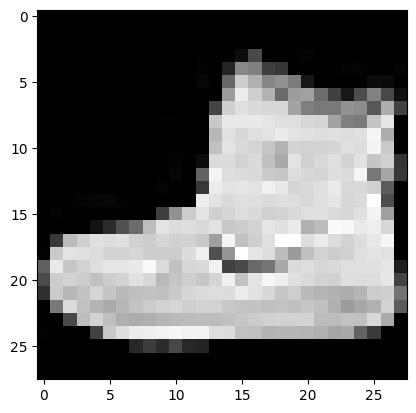

In [26]:
X = X / 2 + 0.5
plt.imshow(np.transpose(X, (1,2,0)), cmap='gray')

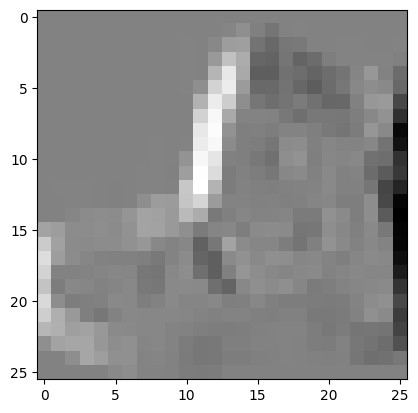

In [27]:
def apply_filter(im, filter):  
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_h] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

# left edgeフィルタでも同様に畳み込み処理を行う
left_edge_filter = torch.tensor([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]])

def relu(X):
    return torch.clamp(X, min=0)

X = X[0, :, :]
conv_out = apply_filter(X, left_edge_filter)
plt.imshow(conv_out, cmap='gray')

In [28]:
print(conv_out.mean(), conv_out.std())

tensor(0.0442) tensor(0.6041)


In [29]:
conv_out = conv_out[None, None, :, :]
norm_out = batch_norm(conv_out, )

In [30]:
# 平均0、標準偏差1になっているのがわかる
print(norm_out.mean(), norm_out.std())

tensor(-1.6224e-08) tensor(1.0000)


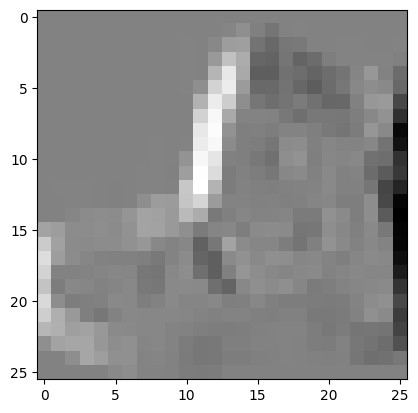

In [31]:
plt.imshow(norm_out[0, 0, :, :], cmap='gray')

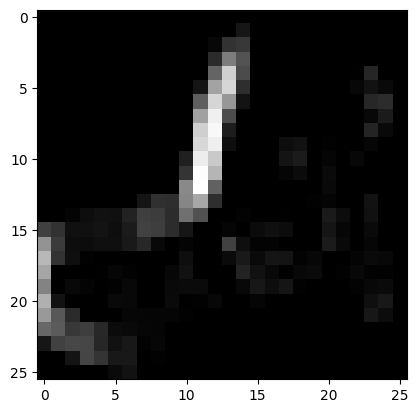

In [32]:
relu_out = relu(norm_out)
relu_out = relu_out[0, 0, :, :]
plt.imshow(relu_out, cmap='gray')

### Pytorchのバッチ正規化層を使う

nn.BatcgNorm2d
- nn.BatchNorm2d()を畳み込み層の後に配置する
    - num_features: 正規化される特徴マップの数。通常直前の畳み込み層の出力channel数を指定する
- 全結合層の場合は、nn.BatchNorm1d()を全結合層の後に配置する
    - num_features: 正規化される特徴量の数。通常直前の全結合層の出力次元を指定する

In [33]:
X, y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
norm_out = nn.BatchNorm2d(8)(conv_out)

In [34]:
X.shape

torch.Size([1024, 1, 28, 28])

In [35]:
print(conv_out.mean(), conv_out.std())
print(norm_out.mean(dim=(0,2,3)), norm_out.std(dim=(0,2,3)))

tensor(0.0386, grad_fn=<MeanBackward0>) tensor(0.4986, grad_fn=<StdBackward0>)
tensor([ 5.9244e-08,  2.5668e-08, -7.8659e-08,  2.4614e-09,  3.4497e-08,
         1.7239e-08,  2.7750e-09,  1.3970e-09], grad_fn=<MeanBackward1>) tensor([1.0000, 1.0000, 0.9998, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000],
       grad_fn=<StdBackward0>)


In [36]:
list(nn.BatchNorm2d(9).parameters())

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [37]:
# Batch Norm有りのCNNモデル得る関数
def get_conv_model():
    return nn.Sequential(
        # 1x28x28
        nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(4), 
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        # 32x2x2 -> GAP -> 32 x 1 x 1
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(32, 10)
    )

In [38]:
conv_model_w_bn = get_conv_model()

In [39]:
act_stats = ActivationStatistics(conv_model_w_bn)

In [40]:
# Bacth Normをつけると学習が安定して早く進み、比較的最初の方から精度が高くなる（高速化）
opt = optim.SGD(conv_model_w_bn.parameters(), lr=0.6)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_bn, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.8983693274401002, validation error: 0.589528638124466, validation accuracy: 0.7893953263759613


epoch: 1: train error: 0.4769870583283699, validation error: 0.47123314440250397, validation accuracy: 0.8266641438007355


epoch: 2: train error: 0.4191036199109029, validation error: 0.4742902100086212, validation accuracy: 0.8274154961109161


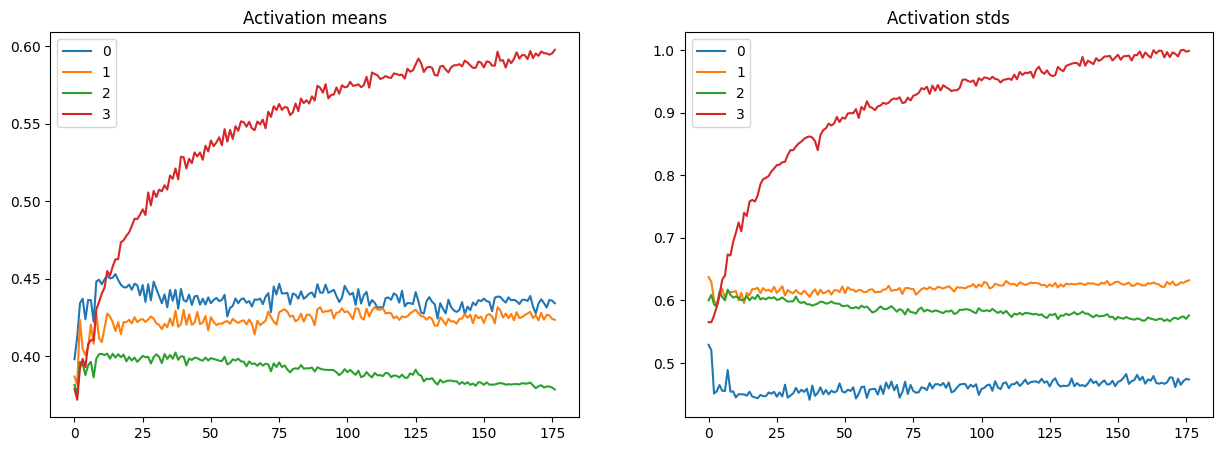

In [41]:
act_stats.plot_statistics()

## Layer Normalization

### Layer Normのスクラッチ

- 入力tensorに対して、平均と標準偏差を計算する
- スケーリングとシフト用の係数(gamma, beta)も引数として受け取る形
    - 本来は学習可能なパラメータだが、今回の実装では引数として受け取る形を取る
- 入力tensorは[B, C, H, W]を想定する

In [46]:
# batch_normのスクラッチ
def batch_norm(X, gamma=1, beta=0, eps=1e-5):
    mean = X.mean(dim=(0, 2, 3), keepdim=True)
    var = X.var(dim=(0, 2, 3), keepdim=True)
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma*X_norm + beta

# layer_normのスクラッチ
def layer_norm(X, gamma=1, beta=0, eps=1e-5):
    mean = X.mean(dim=(1, 2, 3), keepdim=True)
    var = X.var(dim=(1, 2, 3), keepdim=True)
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma*X_norm + beta

In [47]:
X = torch.randn([5, 3, 3, 3])
norm_out = layer_norm(X)
norm_out.shape

torch.Size([5, 3, 3, 3])

In [53]:
print(X[0].mean(), norm_out[0].mean())
print(X[0].std(), norm_out.std())

tensor(-0.1918) tensor(-1.7661e-08)
tensor(0.6210) tensor(0.9850)


### PytorchのLayer Norm層を使う

nn.LayerNorm()
- nn.LayerNorm()を畳み込み層や全結合の直後に配置する
  - normalized_shape: 正規化するtensorのshape。通常直前の畳み込み層の出力サイズ([C, H, W])を指定する。全結合の場合は出力の次元に注意する。

In [66]:
X, y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
print(X.shape, conv_out.shape)

print('----------')
norm_out = nn.LayerNorm([8, 14, 14])(conv_out)
print(conv_out[0].mean(), conv_out[0].std())
print(norm_out[0].mean(), norm_out[0].std())

torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 14, 14])
----------
tensor(0.0683, grad_fn=<MeanBackward0>) tensor(0.4859, grad_fn=<StdBackward0>)
tensor(9.1232e-09, grad_fn=<MeanBackward0>) tensor(1.0003, grad_fn=<StdBackward0>)


In [36]:
list(nn.LayerNorm(9).parameters())

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [72]:
# Layer Norm有りのCNNモデル得る関数
def get_conv_model_ln():
    return nn.Sequential(
        # 1x28x28
        nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([4, 14, 14]), 
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([8, 7, 7]), 
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([16, 4, 4]), 
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm([32, 2, 2]), 
        nn.ReLU(),
        # 32x2x2 -> GAP -> 32 x 1 x 1
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(32, 10)
    )

# モデル作成
conv_model_w_ln = get_conv_model_ln()
act_stats = ActivationStatistics(conv_model_w_ln)

# 学習
opt = optim.SGD(conv_model_w_ln.parameters(), lr=0.6)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_ln, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 1.3508958018432229, validation error: 0.8427382588386536, validation accuracy: 0.7015326023101807


epoch: 1: train error: 0.8237847241304689, validation error: 0.6907421708106994, validation accuracy: 0.755279415845871


epoch: 2: train error: 0.6105280811503783, validation error: 0.5669686794281006, validation accuracy: 0.7976422965526581


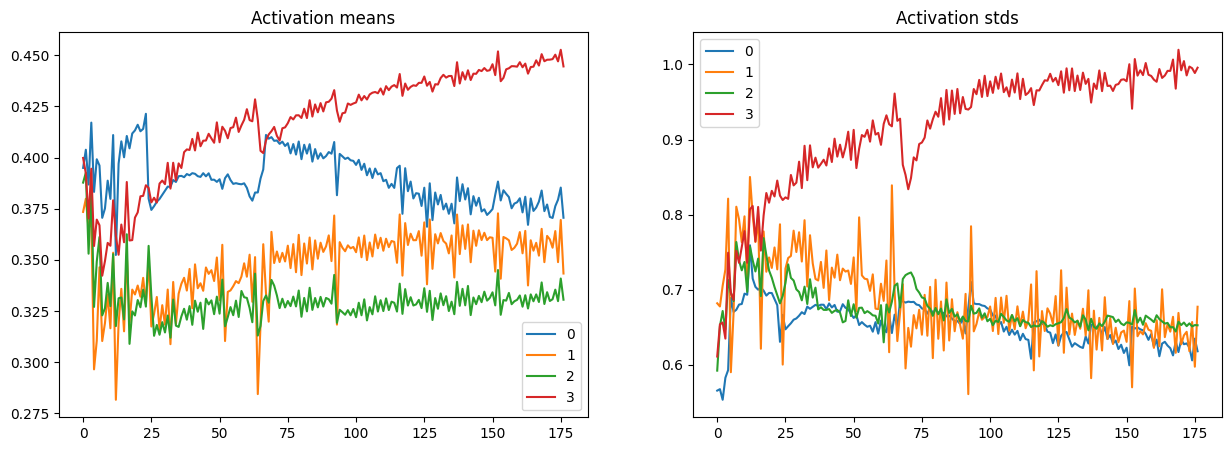

In [75]:
# Batch Normの方が滑らかに学習が進んでいるが、正規化を行なっていないものと比べるとまだマシに学習が進んでいる
# Normがない時は学習時にスパイクがあったりしうまく学習が進んでいなかった
# 画像の時はBatch Norm、RNNではLayer Normをよく多用する
act_stats.plot_statistics()